# Cell growth on the standard model for a bioreactor (product excluded) with an input

The goal is to use a simple DGL that displays the characteristic behavior for Substrate consumption and Biomass growth for Data, then train a NN, DMD, or a gaussian Model with it. Afterwards, some values (e.g in the growth rate $\mu(S)$-the Km-value) are in the DGL are changed to generate a new output for the Biomass. Then it is attempted to design an observer, that can make the (now flawed) model converge to the real states.

The system of DGLs that will be used here is :


$$
\begin{aligned}
\dot{b} &= -Db + \rho(s)b \\
\dot{s} &= D(s_e - s) - \rho(s)b
\end{aligned}
$$
with the biomass being the measured output, so that 
$$y(t)=b(t)$$ 
 
Now to start we have to ensure the input is valid. By that i mean that D should not be negative. For growth of cells it can be observed, that D should not be larger than the value of $rho$, as this would lead to all the cells being washed out of the reactor. It can also be observed, that the value of D does influence the Cell growth in two ways: 
- washes out cells
- increases the growth rate by increasing rho

for the biomass there are only 2 equilibria: 
either b is 0 or it can be arbitrary, as long as $D=\rho(s)$, while $s=f(D,b,\rho)$



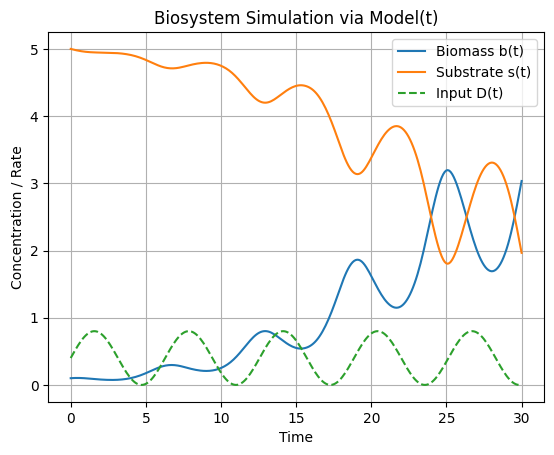

In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import helperfunctions as hf
from easy_system_input_models import BiosystemModel


#i created a class, to make it a bit easier -->example usage


params={'K_m':2,
        's_e':5,
        'mu_max':0.8,
        }

# Sinoid input
def D_func_1(t,i):
    return np.sin(t/i)/2.5 + 0.4

def D_func_2(t,i):
    return np.ones_like(t) * i

# Wrap your D_func_1 to only require t
D_func_sin = lambda t: D_func_1(t,i=1)
D_func_step= lambda t: D_func_2(t,i=2/7)


# Instantiate model
biosystem_model = BiosystemModel(**params)


# Define time vector and solve
t_eval = np.linspace(0, 30,300)
x0=[0.1,5]
sol = biosystem_model(t_eval,x0,D_func_sin)

# Plot results
plt.plot(sol.t, sol.y[0], label='Biomass b(t)')
plt.plot(sol.t, sol.y[1], label='Substrate s(t)')
plt.plot(sol.t, D_func_sin(sol.t), '--', label='Input D(t)')
plt.xlabel('Time')
plt.ylabel('Concentration / Rate')
plt.legend()
plt.grid(True)
plt.title('Biosystem Simulation via Model(t)')
plt.show()




# <u> **1. Models** </u>

# <u> Neural Network setup and traing Data </u>

Since we now have an input it should be attempted to also model this into the system. Just as i did for the batch case i will do $j$ different initial conditions. However, for each initial condition i will also use $k$ different inputs so i have a total of $j\cdot k$ training sets

In [2]:
#creating and storing more datasets with the same parameters but different initial conditions

Dataset = {}
j = 10
N_inputfunctions = 2
N_variations_per_function = 5

counter = 0  # unique index for each dataset entry

for i in range(j):
    y0 = [0.1, 1 + 0.3*i]

    for k in range(N_variations_per_function):
        # define variations of inputs
        D_func_sin_training = lambda t, kk=k: D_func_1(t, i=kk+1)  # capture k correctly
        D_func_step_training = lambda t, kk=k: D_func_2(t, i=kk/7)

        # solve with both inputs
        sol_sin_input = biosystem_model(t_eval, y0, D_func_sin_training)
        sol_step_input = biosystem_model(t_eval, y0, D_func_step_training)

        
        Dataset[f'B{counter}'] = sol_sin_input.y[0]
        Dataset[f'S{counter}'] = sol_sin_input.y[1]
        Dataset[f'U{counter}'] = D_func_sin_training(t_eval)
        counter += 1

       
        Dataset[f'B{counter}'] = sol_step_input.y[0]
        Dataset[f'S{counter}'] = sol_step_input.y[1]
        Dataset[f'U{counter}'] = D_func_step_training(t_eval)
        counter += 1
    



In [3]:

from easy_system_input_models_torch import Neuralnetwork
import torch as torch
import torch.nn as nn

#initializing the neural network class that inherits from nn
dim=2                           #b,s and u
    
classicNN_model = Neuralnetwork(dim=dim)
optimizer = torch.optim.Adam(classicNN_model.parameters(), lr=1e-3)
criterion = nn.MSELoss() #mean squared error loss function --randomly chosen, could also use weighted function
#weighted function may be good, to value the larger Cells more, since the measurement of these is generally more stable than 
#the measurement of small cells

# #stack the datasets together
"""commented out because i already trained it"""
# all_data = []
# for i in range(j*N_inputfunctions*N_variations_per_function):
#     d = torch.tensor(
#         np.stack([Dataset[f'B{i}'], Dataset[f'S{i}'],Dataset[f'U{i}']], axis=1),
#         dtype=torch.float32
#     )
#     all_data.append(d)

# # stack all trajectories into one big dataset
# X_list, Y_list = [], []
# for data in all_data:
#     X_list.append(data[:-1, :])    # inputs
#     Y_list.append(data[1:, 0:2])   # targets

# X = torch.cat(X_list, dim=0)   # [N_total, 3]
# Y = torch.cat(Y_list, dim=0)   # [N_total, 2]

# for epoch in range(10001):
#     optimizer.zero_grad()
#     output = classicNN_model(X)           # [N_total, 2]
#     loss = criterion(output, Y) # single scalar loss
#     loss.backward()
#     optimizer.step()

#     if epoch % 1000 == 0:
#         print(f"Epoch {epoch}, Loss: {loss.item():.6f}")


'commented out because i already trained it'

# Validation of the NN with different initial conditions
 
it can be observed, that there is definitely a mismatch between the real trajectory and the predicted trajectory.
-->Checking whether an Observer can help to get the real states of the system, even with wrong initial guess


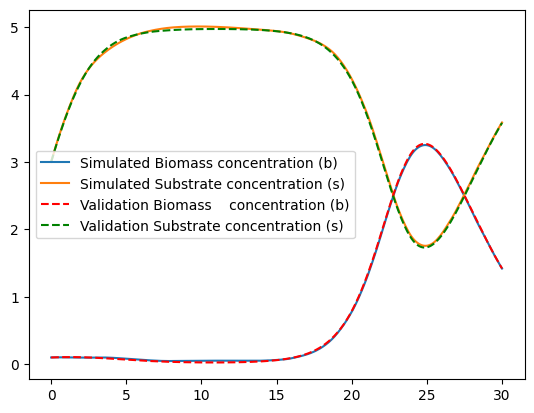

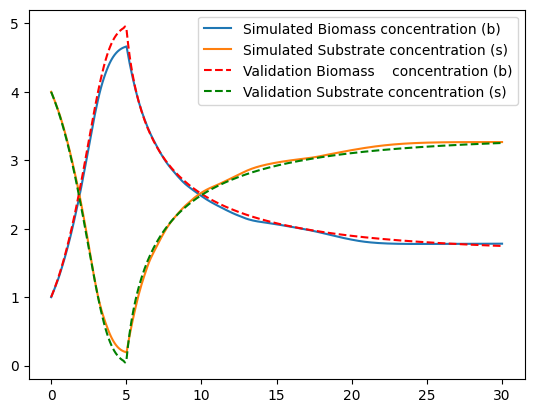

In [4]:

y0=[0.1,3] #initial conditions for the validation with the neural network
y0_2=[1,4]

#create new (not trained) inputs (e.g.a sinus with a new frequency only turn up the step after 5 seconds)
D_func_sin_val = lambda t: D_func_1(t,i=4)
def D_func_step_val(t):
    return np.where(t < 5, 0.0, 0.5)

classicNN_model.load_state_dict(torch.load(".\Trained_easy_system_models_input\classicNN_easy_system_input_(3x128x128x128x128x2)1e4epoch.pth"))
validation=biosystem_model(t_eval,y0,D_func_sin_val)
validation_2=biosystem_model(t_eval,y0_2,D_func_step_val)
Dataset_val = {}
Dataset_val['B1'] = validation.y[0]
Dataset_val['S1'] = validation.y[1]
Dataset_val['U1'] = D_func_sin_val(t_eval)

Dataset_val['B2'] = validation_2.y[0]
Dataset_val['S2'] = validation_2.y[1]
Dataset_val['U2']= D_func_step_val(t_eval)

##NN simulation

sol_sim = [y0]   # initial state
for i in range(len(t_eval) - 1):
    sol_prev = sol_sim[i]      # previous state [b, s]
    u = D_func_sin_val(t_eval[i]) # input D(t)
    
    # Make 1x3 input row for NN: [b, s, D]
    x = np.array([[sol_prev[0], sol_prev[1], u]], dtype=np.float32)
    x_tensor = torch.tensor(x)

    # Predict next state
    ni = classicNN_model(x_tensor).detach().numpy()
    sol_sim.append(ni[0])      # ni[0] because model output shape is (1,2) and we want (2,)


plt.plot(t_eval, np.array(sol_sim)[:, 0], label='Simulated Biomass concentration (b)')
plt.plot(t_eval, np.array(sol_sim)[:, 1], label='Simulated Substrate concentration (s)')
plt.plot(validation.t, validation.y[0], 'r--', label='Validation Biomass    concentration (b)')
plt.plot(validation.t, validation.y[1], 'g--', label='Validation Substrate concentration (s)')
plt.legend(loc='best')
plt.show()

sol_sim=[y0_2]
for i in range(len(t_eval) - 1):
    sol_prev = sol_sim[i]      # previous state [b, s]
    u = D_func_step_val(t_eval[i]) # input D(t)
    
    # Make 1x3 input row for NN: [b, s, D]
    x = np.array([[sol_prev[0], sol_prev[1], u]], dtype=np.float32)
    x_tensor = torch.tensor(x)

    # Predict next state
    ni = classicNN_model(x_tensor).detach().numpy()
    sol_sim.append(ni[0])      # ni[0] because model output shape is (1,2) and we want (2,)
    
plt.plot(t_eval, np.array(sol_sim)[:, 0], label='Simulated Biomass concentration (b)')
plt.plot(t_eval, np.array(sol_sim)[:, 1], label='Simulated Substrate concentration (s)')
plt.plot(validation.t, Dataset_val['B2'], 'r--', label='Validation Biomass    concentration (b)')
plt.plot(validation.t, Dataset_val['S2'], 'g--', label='Validation Substrate concentration (s)')
plt.legend(loc='best')
plt.show()
# torch.save(classicNN_model.state_dict(), 'classicNN_easy_system_input_(3x128x128x128x128x2)epoch.pth')

# Problems with input
The normal NN  fit the data pretty very well. This could maybe even be improved using **Recurrent Neural Networks** or maybe trying to implement a **MULIT-STEP-LOSS***, where the loss is calculated through the prediction of a couple forward steps and then punishing the offset. I am thinking that maybe a slow reaction of the system to a fast changing input might be better modelled this way. see below... but this took forever, maybe i fix it if i got time


### Multi step Loss
Issue: takes a really long time to calculate the loss and backprop, since we use the model itself n times per stride to calculate the prediction. The basic idea is this. Pseudo code incoming watch out: 

        for each training iteration we have a sliding window of a step size n (e.g. n=5)
            Then we take the value x_true (t)
            x_pred=x_true
            for step in n:
                Take u(t+step)
                predict the next state with x_pred and u as input
                update x_pred
                loss =xtrue(t+n+1)-xpred
With this we basically have a similar approach as we did with the Moving Horizon estimation. To sort of reduce the time i also introduced a stride, which basically gives us how much overlap we have per iteration. With stride=1 we move the window by 1 after each step loop has been cleared, with step=2 we move the window by 2... and so on



In [5]:

import torch as torch
import torch.nn as nn
import torch.nn as nn
import numpy as np
from easy_system_input_models_torch import Neuralnetwork

# Model (unchanged)
dim = 2


NN_sliding_window = Neuralnetwork(dim=dim)
optimizer = torch.optim.Adam(NN_sliding_window.parameters(), lr=1e-3)
criterion = nn.MSELoss()

# ---------- STACK ALL TRAJECTORIES INTO ONE BIG BATCH -----------
all_data = []
for i in range(j * N_inputfunctions * N_variations_per_function):
    d = torch.tensor(
        np.stack([Dataset[f'B{i}'], Dataset[f'S{i}'], Dataset[f'U{i}']], axis=1),
        dtype=torch.float32
    )
    all_data.append(d)

all_data = torch.stack(all_data)   # [N, T, 3]

# ------------------ Training Settings 
n_steps = 5     # horizon for multi-step training
stride = 1
epochs = 1000

N, T, _ = all_data.shape

# for epoch in range(epochs):
#     optimizer.zero_grad()
#     total_loss = 0.0

#     # Split into state and input parts
#     B = all_data[:, :, 0:1]  # [N, T, 1]
#     S = all_data[:, :, 1:2]  # [N, T, 1]
#     U = all_data[:, :, 2:3]  # [N, T, 1]

#     # === Loop over time indices (one loop for all   N trajectories) ===
#     for t in range(0, T - n_steps - 1, stride):
#         # Start at true state for all trajectories at time t
#         state_pred = all_data[:, t, 0:2]   # [N, 2] (2 because dim x=2--> x states for all trajectories)

#         for step in range(n_steps):
#             # Prepare input for ALL trajectories at once
#             input_vec = torch.cat((state_pred, U[:, t+step, :]), dim=1)  # [N, 3]

#             # Predict next state for ALL trajectories (at t+step+1)
#             state_pred = NN_sliding_window(input_vec)  # [N, 2]

#             # Add loss for ALL trajectories
#             total_loss += criterion(state_pred, all_data[:, t+step+1, 0:2])

#     # Normalize loss
#     total_loss = total_loss / ((T - n_steps - 1) / stride * n_steps)

#     # Backpropagation
#     total_loss.backward()
#     optimizer.step()

#     if epoch % 10 == 0:
#         print(f"Epoch {epoch}, Loss: {total_loss.item():.6f}")


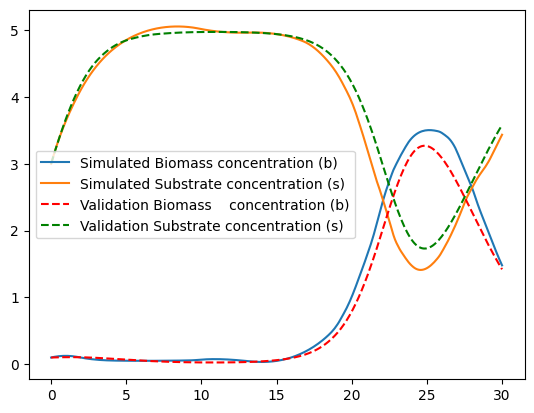

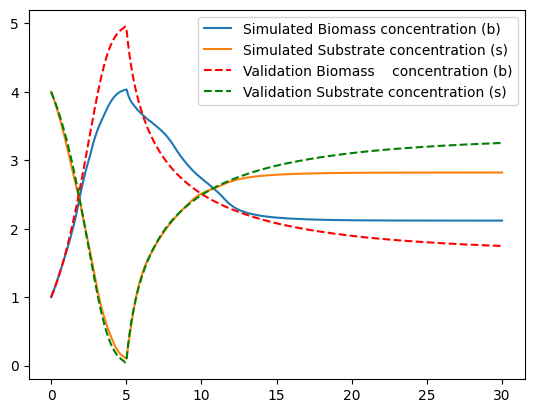

In [6]:
y0=[0.1,3] #initial conditions for the validation with the neural network
y0_2=[1,4]

NN_sliding_window.load_state_dict(torch.load("./Trained_easy_system_models_input/NN_sliding_window_easy_system_input_(3x128x128x128x128x2)ReLU_epoch.pth"))
#create new (not trained) inputs (e.g.a sinus with a new frequency only turn up the step after 5 seconds)
D_func_sin_val = lambda t: D_func_1(t,i=4)
def D_func_step_val(t):
    return np.where(t < 5, 0.0, 0.5)

NN_sliding_window.eval()
validation=biosystem_model(t_eval,y0,D_func_sin_val)
validation_2=biosystem_model(t_eval,y0_2,D_func_step_val)
Dataset_val = {}
Dataset_val['B1'] = validation.y[0]
Dataset_val['S1'] = validation.y[1]
Dataset_val['U1'] = D_func_sin_val(t_eval)

Dataset_val['B2'] = validation_2.y[0]
Dataset_val['S2'] = validation_2.y[1]
Dataset_val['U2']= D_func_step_val(t_eval)

##NN simulation

sol_sim = [y0]   # initial state
for i in range(len(t_eval) - 1):
    sol_prev = sol_sim[i]      # previous state [b, s]
    u = D_func_sin_val(t_eval[i]) # input D(t)
    
    # Make 1x3 input row for NN: [b, s, D]
    x = np.array([[sol_prev[0], sol_prev[1], u]], dtype=np.float32)
    x_tensor = torch.tensor(x)

    # Predict next state
    ni = NN_sliding_window(x_tensor).detach().numpy()
    sol_sim.append(ni[0])      # ni[0] because model output shape is (1,2) and we want (2,)


plt.plot(t_eval, np.array(sol_sim)[:, 0], label='Simulated Biomass concentration (b)')
plt.plot(t_eval, np.array(sol_sim)[:, 1], label='Simulated Substrate concentration (s)')
plt.plot(validation.t, validation.y[0], 'r--', label='Validation Biomass    concentration (b)')
plt.plot(validation.t, validation.y[1], 'g--', label='Validation Substrate concentration (s)')
plt.legend(loc='best')
plt.show()

sol_sim=[y0_2]
for i in range(len(t_eval) - 1):
    sol_prev = sol_sim[i]      # previous state [b, s]
    u = D_func_step_val(t_eval[i]) # input D(t)
    
    # Make 1x3 input row for NN: [b, s, D]
    x = np.array([[sol_prev[0], sol_prev[1], u]], dtype=np.float32)
    x_tensor = torch.tensor(x)

    # Predict next state
    ni = NN_sliding_window(x_tensor).detach().numpy()
    sol_sim.append(ni[0])      # ni[0] because model output shape is (1,2) and we want (2,)
    
plt.plot(t_eval, np.array(sol_sim)[:, 0], label='Simulated Biomass concentration (b)')
plt.plot(t_eval, np.array(sol_sim)[:, 1], label='Simulated Substrate concentration (s)')
plt.plot(validation.t, Dataset_val['B2'], 'r--', label='Validation Biomass    concentration (b)')
plt.plot(validation.t, Dataset_val['S2'], 'g--', label='Validation Substrate concentration (s)')
plt.legend(loc='best')
plt.show()
# torch.save(NN_sliding_window.state_dict(), 'NN_sliding_window_easy_system_input_(3x128x128x128x128x2)ReLU_epoch.pth')

# <u>NEURAL ODEs</u>


Neural ODEs are a type of deep neural network, where instead of specifying a discrete sequence of hidden layers, the **derivative of the hidden state** (from the hidden layers) is parameterized using a neural network. Using a differential equation solver, we obtain the output.

One great advantage is the ability to model **continuous-time data**, since we approximate a continuous function rather than perform a discrete forward shift.

##  Hidden State Dynamics

Denoting the hidden state as $h(t)$,  the goal is to approximate:
$$
\frac{dh(t)}{dt} = f(h(t), t, \theta)
$$
The actual states $h(t)$ can then be computed using an ODE solver.



##  Backpropagation and Adjoint Sensitivity

Backpropagation through an ODE solver can lead to:
- High memory cost (storing full trajectories)
- Numerical instability due to solver approximations

To address this, the authors of [Neural Ordinary Differential Equations](https://arxiv.org/abs/1806.07366) introduced the **adjoint sensitivity method** (related to Pontryagin's Maximum Principle). The key idea is to **solve a second, augmented ODE *backward in time***.


However i want to stress that normal backpropagation does also work perfectly fine, it is just higher in memory cost.

---
## Loss Function

We define the loss function as:
$$
L(z(t_1)) = L\left(z(t_0) + \int_{t_0}^{t_1} f(z(t), t, \theta) \, dt\right) = L\left(\text{ODESolve}(z(t_0), f, t_0, t_1, \theta)\right)
$$

This yields the optimization problem:
$$
\arg\min_{\theta} L(z(t_1))
$$

As mentioned above, solving directly for the weights results in too much computational load and can introduce errors. So we introduce the following **constraint** based on the system dynamics:
$$
F\left(\dot{z}(t), z(t), \theta, t\right) = \dot{z}(t) - f(z(t), \theta, t) = 0
$$

Here, $\theta$ refers to the weights of the neural network.



## Lagrangian Formulation

Incorporating this constraint into the loss using a Lagrange multiplier $\lambda(t)$, we obtain the Lagrangian:
$$
\psi = L(z(t_1)) - \int_{t_0}^{t_1} \lambda(t) \, F\left(\dot{z}(t), z(t), \theta, t\right) \, dt
$$

Note that the constraint $ F = 0$ doesn't change the solution, because we are optimizing over trajectories that already satisfy:
$$
\dot{z}(t) = f(z(t), \theta, t)
$$

So, with **infinite storage and without numerical instabilities**, direct backpropagation of the loss $ L(z(t_1))$ with respect to $ \theta $ would yield the same result.

In practice, however, backpropagation introduces computational and numerical problems. With this formulation, we can **choose the Lagrange multiplier** in a way that **avoids computing hard derivatives** like:
$$
\frac{dz(t_1)}{d\theta}
$$


##  The Adjoint Equation

After some calculations (explained [here](https://vaipatel.com/posts/deriving-the-adjoint-equation-for-neural-odes-using-lagrange-multipliers/)), we arrive at an ODE for the Lagrange multiplier (also called the **adjoint**):
$$
\frac{d\lambda(t)}{dt} = -\lambda(t)^T \, \frac{\partial f(z(t), t, \theta)}{\partial z}
$$

This is solved **backward in time** from $t_{1}$ to $ t_{0} $.



## Final Gradient Expression

Finally, we obtain the derivative of the loss with respect to the parameters $\theta $:
$$
\frac{dL}{d\theta} = - \int_{t_1}^{t_0} \lambda(t)^T \, \frac{\partial f(z(t), t, \theta)}{\partial \theta} \, dt
$$

Note: the integration goes from $t_{1}$ to $ t_{0}$,  consistent with the backward nature of the adjoint method.


NOTE2 for input training: i have more datasets, as i wanted to train different inputs for each initial condition. However, this leads to really long compution times in training. Almost 90s per epoch and i need at least 1000 epochs, so this might not be feasible. This is why i try to batch the Training data. this avoids calling the odeint solver for every dataset seperately which saves some time.


In [7]:
#prepare Training data 
import torch
import torch.nn as nn
from torchdiffeq import odeint,odeint_adjoint
import numpy as np

# === Setup ===
t = torch.tensor(t_eval, dtype=torch.float32)   # [T]
dim_x = 2    # B, S
dim_u = 1    # U
learning_rate = 1e-2#for training speed --might also cause divergence if too high though
epochs = 40000

# === Prepare dataset ===
# Collect all trajectories into one big tensor for batching
all_data = []
for i in range(j * N_inputfunctions * N_variations_per_function):
    d = torch.tensor(
        np.stack([Dataset[f'B{i}'], Dataset[f'S{i}'], Dataset[f'U{i}']], axis=1),
        dtype=torch.float32
    )
    all_data.append(d)

# Stack into shape [N, T, 3]            N=nr of batches, T=timesteps, 3= dimx+dimu
all_data = torch.stack(all_data)   # [N, T, 3]

# Split into states (x) and inputs (u)
x_true = all_data[:, :, :dim_x]    # [N, T, 2]
u_seq  = all_data[:, :, dim_x:]    # [N, T, 1]

N, T, _ = all_data.shape
x0 = x_true[:, 0, :]               # [N, 2] - initial state for each trajectory


In [8]:
from easy_system_input_models_torch import ODEFunc

# === Instantiate model and optimizer ===
func = ODEFunc(dim_x, dim_u, t, u_seq)
optimizer = torch.optim.Adam(func.parameters(), lr=learning_rate)
"""commented out because i dont always want to retrain the model"""
# === Loss function ===
def myloss_fn(pred, true):
    return torch.mean((pred - true) ** 2)

# === Training loop ===
# best_loss = float('inf')
# best_state = None

# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
#     optimizer,
#     mode='min',    # we want to minimize loss
#     factor=0.5,    # halve the LR each time patience is exceeded
#     patience=30    # wait 20 epochs without improvement
# )

# for epoch in range(epochs):
#     optimizer.zero_grad()

#     # Integrate for all trajectories in parallel
#     x_pred = odeint_adjoint(func, x0, t, method='rk4',rtol=1e-6,atol=1e-7)  # [T, N, dim_x]

#     # Reorder to [N, T, dim_x] for loss comparison
#     x_pred = x_pred.permute(1, 0, 2)

#     # Compute loss across all trajectories and time steps
#     loss = myloss_fn(x_pred, x_true)

#     # Backpropagation
#     loss.backward()
#     optimizer.step()

#     # Track the best model
#     if loss.item() < best_loss:
#         best_loss = loss.item()
#         best_state = func.state_dict()  # copy the model params

#     # Step the scheduler (important: AFTER optimizer.step)
#     scheduler.step(loss)

#     if epoch % 10 == 0:
#         print(f"Epoch {epoch}, Loss: {loss.item():.6f}, Best loss: {best_loss:.6f}")

# # Restore the best model weights after training
# if best_state is not None:
#     func.load_state_dict(best_state)
#     print(f" Restored best model parameters with loss = {best_loss:.6f}")
# torch.save(func.state_dict(), "neural_ode_easy_model_(3x64x64x2)_tanh_40000epoch.pth")




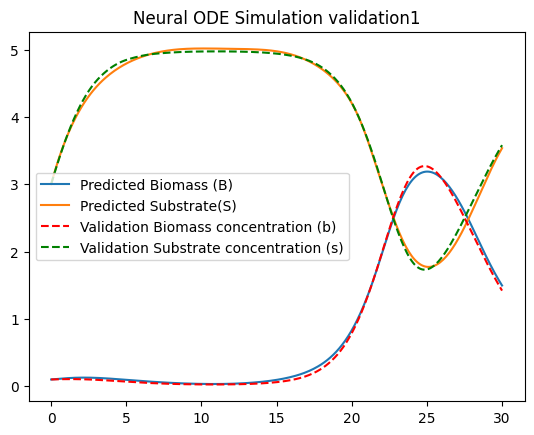

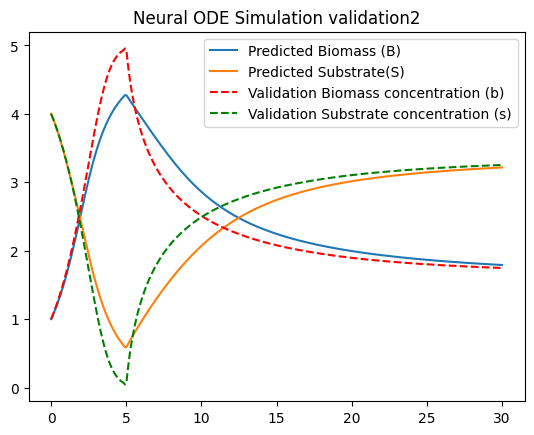

In [9]:
state_dict = torch.load(r".\Trained_easy_system_models_input\neural_ode_easy_model_(3x64x64x2)_tanh_40000epoch.pth")
func.load_state_dict(state_dict)
func.eval()


# Initial conditions for two trajectories
z0_1 = torch.tensor([Dataset_val['B1'][0], Dataset_val['S1'][0]], dtype=torch.float32)  # shape (2,)
z0_2 = torch.tensor([Dataset_val['B2'][0], Dataset_val['S2'][0]], dtype=torch.float32)  # shape (2,)

# Stack them -> batch dimension [2, 2]
z0 = torch.stack([z0_1, z0_2], dim=0)   # shape: (2, 2)

# Time points (same for both)
t = torch.linspace(0, 30, 300)   
T = t.shape[0]

# Input sequences (one sinusoidal, one step) -> shape [2, T, 1]
u_seq_1 = torch.from_numpy(D_func_sin_val(t.numpy())).float().reshape(1, T, dim_u)  
u_seq_2 = torch.from_numpy(D_func_step_val(t.numpy())).float().reshape(1, T, dim_u)
# Concatenate along batch axis
func.u_seq = torch.cat([u_seq_1, u_seq_2], dim=0)   # shape: [2, 300, 1]

# Simulate both in one go
z_pred = odeint(func, z0, t)    # shape: [300, 2, 2]

# Optional: separate them back out
z_pred1 = z_pred[:, 0, :]   # [300, 2] 
z_pred2 = z_pred[:, 1, :]   # [300, 2]
# Simulate (result will be [T, 1, 2])
z_pred1=z_pred1.detach().numpy()
z_pred2=z_pred2.detach().numpy()
plt.figure()
plt.title('Neural ODE Simulation validation1')
plt.plot(t.numpy(), z_pred1[:, 0], label='Predicted Biomass (B)')
plt.plot(t.numpy(), z_pred1[:, 1], label='Predicted Substrate(S)')
plt.plot(validation.t, validation.y[0], 'r--', label='Validation Biomass concentration (b)')
plt.plot(validation.t, validation.y[1], 'g--', label='Validation Substrate concentration (s)')
plt.legend(loc='best')
plt.show()
# torch.save(func.state_dict(), 'neural_ode_model_easy_system_input_2x64x64x2_300epoch.pth')  # Save the model state
# Load the model state
#if you want to load the model after some time without retraining again(as that takes a lot of time)
# func.load_state_dict(torch.load('neural_ode_model_2000epoch.pth'))

plt.figure()
plt.title('Neural ODE Simulation validation2')
plt.plot(t.numpy(), z_pred2[:, 0], label='Predicted Biomass (B)')
plt.plot(t.numpy(), z_pred2[:, 1], label='Predicted Substrate(S)')
plt.plot(t.numpy(), Dataset_val['B2'], 'r--', label='Validation Biomass concentration (b)')
plt.plot(t.numpy(), Dataset_val['S2'], 'g--', label='Validation Substrate concentration (s)')
plt.legend(loc='best')
plt.show()

## Ok fit for the NODE, but not as well as the NN
why does the Data fit so badly over the "random initial condition" but better over the other Data, even though it wasnt trained directly on it??
The plot below explains it... 
Because of the way i  initially generated the  initial conditions for the simulations, i didn't sufficiently cover the input space, i basically desribed a diagonal through it.

Just looking at the batch system equations, it is obvious that the trajectory is just following a diagonal line... So obviously different initial conditions along this line may be well described. This is where the issue here lies
in the future this will be changed



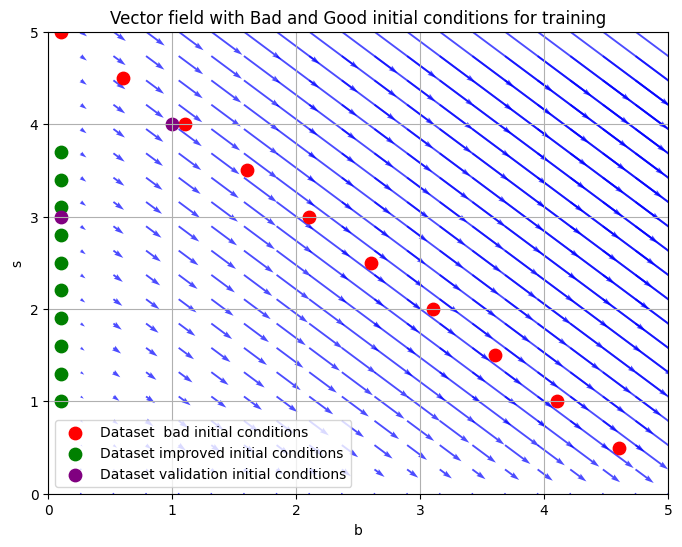

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
mumax = 0.8
Km = 2.0

def rho(s):
    return mumax * s / (Km + s)

# Grid for b and s
b = np.linspace(0, 5, 20)
s = np.linspace(0, 5, 20)
B, S = np.meshgrid(b, s)

dB = rho(S) * B
dS = -rho(S) * B

# Dataset initial badly selected points
i_vals = np.arange(10)
b_points = 0.1 + i_vals * 0.5
s_points = 5.0 - i_vals * 0.5

#Dataset better chosen initial points
b_points_good = 0.1 *np.ones(10)
s_points_good = 1 + i_vals * 0.3

b_validation = [Dataset_val['B1'][0], Dataset_val['B2'][0]]
s_validation = [Dataset_val['S1'][0], Dataset_val['S2'][0]]
plt.figure(figsize=(8, 6))
plt.title("Vector field with Bad and Good initial conditions for training")
plt.xlabel('b')
plt.ylabel('s')

# Plot vector field arrows
plt.quiver(B, S, dB, dS, angles='xy', scale_units='xy', scale=3, color='blue', alpha=0.7)

# Plot dataset initial points
plt.scatter(b_points, s_points, color='red', s=80, label='Dataset  bad initial conditions')
plt.scatter(b_points_good,s_points_good,color='green',s=80,label="Dataset improved initial conditions")
plt.scatter(b_validation,s_validation,color='purple',s=80,label="Dataset validation initial conditions")


plt.legend(loc='lower left')
plt.grid(True)
plt.xlim([0, 5])
plt.ylim([0, 5])
plt.show()

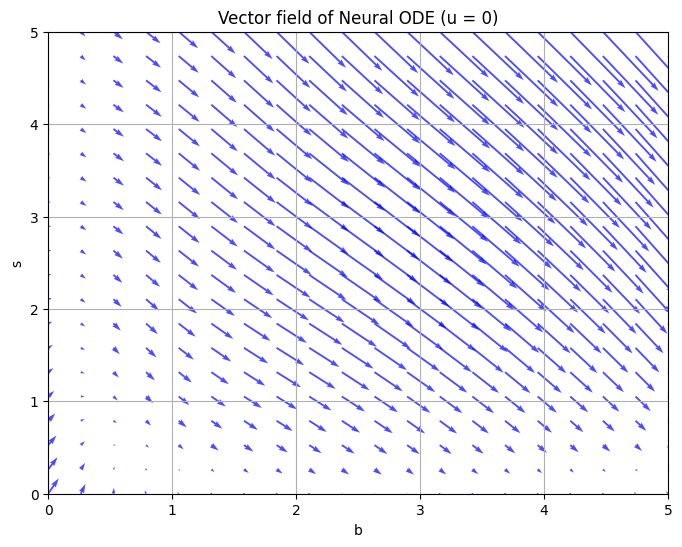

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import torch

def plot_odefunc_vector_field(func, u_value=0.1, b_range=(0,5), s_range=(0,5), grid_points=20):
    """
    Plot the vector field of the learned ODEFunc model.

    func:        trained ODEFunc model
    u_value:     constant input D_value for plotting (scalar)
    b_range:     range of biomass axis (tuple)
    s_range:     range of substrate axis (tuple)
    grid_points: number of grid points along each axis
    """
    func.u_seq=torch.full((1,1,1),u_value)
    # Make a grid
    b = np.linspace(*b_range, grid_points)
    s = np.linspace(*s_range, grid_points)
    B, S = np.meshgrid(b, s)

    # Container for derivatives
    dB = np.zeros_like(B)
    dS = np.zeros_like(S)

    # Evaluate the model at each grid point
    for i in range(grid_points):
        for j in range(grid_points):
            x = torch.tensor([[B[i, j], S[i, j]]], dtype=torch.float32)  # [1, 2]
            u = torch.tensor([[u_value]], dtype=torch.float32)           # [1, 1]
            dx = func(0, x) if not hasattr(func, "get_u_at_t") else func.forward(0, x)

            dB[i, j], dS[i, j] = dx.detach().numpy().flatten()

    # Plot
    plt.figure(figsize=(8, 6))
    plt.title(f"Vector field of Neural ODE (u = {u_value})")
    plt.xlabel('b')
    plt.ylabel('s')

    # Vector field arrows
    plt.quiver(B, S, dB, dS, angles='xy', scale_units='xy', scale=3, color='blue', alpha=0.7)

    plt.xlim(b_range)
    plt.ylim(s_range)
    plt.grid(True)
    plt.show()

func.t_grid = torch.tensor([0.0])         # dummy time grid

plot_odefunc_vector_field(func, u_value=0)

# <u> DMD and Hankel DMD </u> (skipped for easy model with input because of system dimension)
Another Data based modeling approach is using the "Dynamic mode Decomposition", where the data is used to find a best fit linear operator for the approximation of the nonlinear system such that
$$x_{k+1}=A\cdot x_{k}$$

The practical computation uses the singular value decomposition of the snapshot matrices  
SVD of $X = U \Sigma V^T$ and $X' = A X = A U \Sigma V^T$

To solve for $A$, use the pseudoinverse:
$$
A = X' V \Sigma^{-1} U^T
$$

Where:
- $X = [x_1, ..., x_{m-1}]$ (data matrix of snapshots)
- $X' = [x_2, ..., x_m]$ (data matrix shifted by one step)
- $U, \Sigma, V^T$ are from the SVD of $X$.

This gives the best-fit linear operator $A$ such that $x_{k+1} \approx A x_k$.

If it were the case that the system dimension was very large, then the Matrix $A (dim=n\times n$) would also be very large, thus increasing the computational load siginificantly. Then, it would be reasonable to use a reduced order System.
In our case however, the system Dimension is 2, thus the matrix A is of dimension $2 \times 2$. So this won't be necessary.

However the low dimensionality might lead to another Problem :

---

### Potential Problems: 

Usually the Data-vector is of high dimension. in our case it only has Dimension 2. This means that $A \in 2\times2$ which might not be sufficient to correctly approximate the Nonlinear Dynamics. If that should be the case, we could also look at so called **Hankel DMD's**
Hankel DMDs split the Datavector and  stack the segments  (each shifted by one time index) on top of each other to increase the dimension of the System. 

---

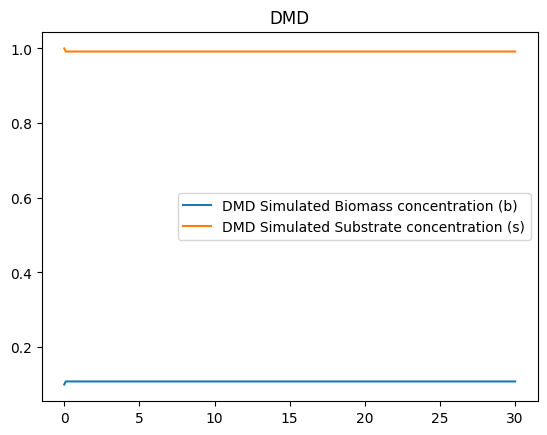

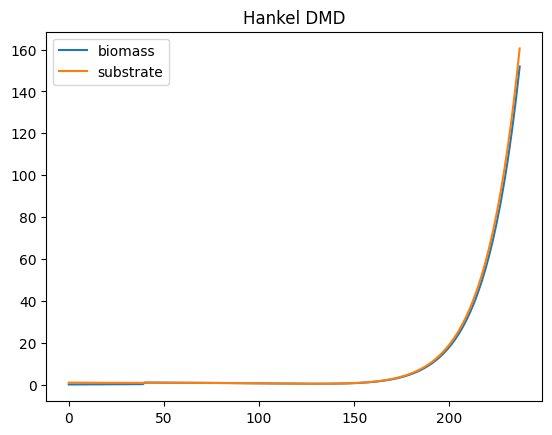

[[ 1.00143722  0.00797712]
 [-0.00143722  0.99202288]]


In [12]:
#DMD of the simulated Dataset
X = np.array([Dataset['B1'][:-1], Dataset['S1'][:-1]])
Xp=np.array([Dataset['B1'][1:], Dataset['S1'][1:]])
A,_,_,_ = hf.compute_DMD(X, Xp)
dim=2           #dimension of our system

#now i want to check whether the DMD matrix can predict the next step on the same dataset 
x0 = np.array([Dataset['B1'][0], Dataset['S1'][0]])
for i in range (0, len(t_eval)):
    xi=A@x0
    if i==0:
        sol_dmd=[x0]
    else:
        sol_dmd.append(xi)


# print(np.array(sol_dmd).shape)
plt.plot(t_eval, np.array(sol_dmd)[:, 0], label='DMD Simulated Biomass concentration (b)')
plt.plot(t_eval, np.array(sol_dmd)[:, 1], label='DMD Simulated Substrate concentration (s)')
plt.title('DMD')
plt.legend()
plt.show()
#As we can see the system is not really capturing the dynamics of the system, so we can attempt the Hankel DMD
#-------------------------------------Hankel DMD------------------------------------

num_columns=8                                      #number of colums to build DMD with
#i dont stack the full matrix, but only up to the 10th column, because if i use the whole snapshot i would already have all the data i need. 
N_snapshots=40
A_hankel,_,_,_ = hf.compute_hankel_DMD(X[:,:N_snapshots], Xp[:,:N_snapshots], cols=num_columns)

#now i want to check whether the Hankel DMD matrix can predict the next step on the same dataset
x0H=hf. stack_snapshots(X=X[:,:N_snapshots], cols=num_columns)
xkH=x0H
sol_hankel=[hf.unstack_snapshots(xkH,dim)]     #so x0,x1,x2...x9 are in here when starting, and i only append the last entry of the Xp to it 
for i in range (1,199):
    xkH=A_hankel@xkH
    sol_hankel.append(hf.unstack_snapshots(xkH,dim)[-1,:])
    

#sol_hankel currently looks like this :[[dim2xsnapshots],[2x1],[2x1]...]-->into matrix
sol_hankel = np.array([
    np.hstack([mat[0] for mat in sol_hankel]),  # Stack all first rows
    np.hstack([mat[1] for mat in sol_hankel])   # Stack all second rows
])
# print(xkH.shape)
plt.plot(sol_hankel[0,:],label='biomass')
plt.plot(sol_hankel[1,:],label='substrate')
plt.legend(loc='best')
plt.title('Hankel DMD')
plt.show()
print(A)

i assume the Hankel DMD does not have enough datapoints to accurately display the dynamics. The substrate should not be increasing at all in this constellation. Thus, i assume the DMD is not really suitable for systems of this order. Usually, when applying DMD a huge datavector for each timestep is provided, sometimes up to 1000 values per timestep. Then a DMD is computed and the system order may be reduced to lower computational load, while still capturing the dynamics. In our case however the low system order seems to cause Problems, as even when stacking the values there only is a relatively low amount of values to use for DMD.

# <u> Gaussian Processes </u> 
The best visual and easy to understand explanation i could find was here:

[Gaussian_Process_not_quite_for_dummies](https://thegradient.pub/gaussian-process-not-quite-for-dummies/)


For many ML-Models, providing an input simply offers you the output as a point/vector.  
GPs however provide a **distribution** to reflect **uncertainties** in the prediction.

The basic idea is putting a distribution over the set of all possible **smooth functions** for the dataset, with the assumption that the output of the set of input points follows a **joint Gaussian distribution**:
$$f(x) \sim \mathcal{GP}(m(x), k(x, x'))$$


Where:  
- $m(x) = \mathbb{E}[f(x)]$ is the **mean function** (often assumed to be 0)  
- $k(x, x') = \mathbb{E}[(f(x) - m(x))(f(x') - m(x'))] $ is the **kernel (covariance function)**

---

### Important factors:

- The **Kernel** is a function which measures the **similarity (or correlation)** between two input points.  
  It defines the **covariance structure** of the Gaussian Process and encodes assumptions about the function being modeled, such as periodicity, or linearity.

- Common kernels are **Radial Basis Function (RBF)** and **Linear kernels**. For example, the RBF kernel:

$$k(x, x') = \sigma_f^2 \exp\left( -\frac{(x - x')^2}{2\ell^2} \right)$$

- The choice of kernel has a **significant impact** on the GP's predictions and its ability to capture the underlying data patterns.

- Often, **hyperparameters** (like $ \ell$, $ \sigma_f $) must be tuned to produce the best result.

---

## GP Regression Prediction

Given a joint Gaussian:

$$
\begin{bmatrix}
y_1 \\
y_2
\end{bmatrix}
\sim \mathcal{N}\left(
\begin{bmatrix}
0 \\
0
\end{bmatrix},
\begin{bmatrix}
A & B \\
B^\top & C
\end{bmatrix}
\right)
$$

The conditional distribution of $y_1$ given $y_2$ is:

$$
y_1 \mid y_2 \sim \mathcal{N}(BC^{-1}y_2,\; A - BC^{-1}B^\top)
$$
with $y_1$ being the estimated states and $y_2$ being the points for which there are measurements.

Where the covariance matrices are computed from the kernel function $k(x, x')$ as:

- $A = k(X_1, X_1)$  
- $B = k(X_1, X_2)$  
- $C = k(X_2, X_2) + \sigma^2 I$  (if observations are noisy)

$X_1$ is the set of points in the input space for which the output is to be estimated , and $X_2$ is the set of points in the input space for which there are measurements available.



  

# GP in Torch (so that i can pass tensors later)
[find_sources_for_my_code](https://docs.gpytorch.ai/en/v1.13/examples/03_Multitask_Exact_GPs/Batch_Independent_Multioutput_GP.html)

In [13]:
import numpy as np
import torch
import gpytorch
from gpytorch.models import ExactGP
from gpytorch.distributions import MultitaskMultivariateNormal
from gpytorch.means import MultitaskMean, ConstantMean
from gpytorch.kernels import MultitaskKernel, RBFKernel
from gpytorch.likelihoods import MultitaskGaussianLikelihood
from gpytorch.mlls import ExactMarginalLogLikelihood
from easy_system_input_models_torch import MultitaskGP

# --- 1. Build training data from j trajectories ---
j = 10  #cant use all trajectories at once yet, might have to use sparse at some point...


X_list, Y_list = [], []
for i in range(j):
    B = Dataset[f'B{i}'].reshape(-1, 1)
    S = Dataset[f'S{i}'].reshape(-1, 1)
    U = Dataset[f'U{i}'].reshape(-1, 1)

    X_traj = np.hstack([B[:-1], S[:-1], U[:-1]])   # [T-1, 3]
    Y_traj = np.hstack([B[1:],  S[1:]])            # [T-1, 2]

    X_list.append(X_traj)
    Y_list.append(Y_traj)

X_np = np.vstack(X_list)  # [N, 3]
Y_np = np.vstack(Y_list)  # [N, 2]

# --- 2. Convert to torch ---
X_train = torch.from_numpy(X_np).float()  # [N, 3]
Y_train = torch.from_numpy(Y_np).float()  # [N, 2]


# --- 3. Set up likelihood & model ---
likelihood = MultitaskGaussianLikelihood(num_tasks=2)
model = MultitaskGP(X_train, Y_train, likelihood)

# --- 4. Train ---
model.train()           #puts them into traingin mode--> lenghtscales etc are set to require gradients 
likelihood.train()

optimizer = torch.optim.Adam(
    model.parameters(),  # includes both mean/covar *and* likelihood
    lr=0.1
)
mll = ExactMarginalLogLikelihood(likelihood, model)

for i in range(61):
    optimizer.zero_grad()
    output = model(X_train)         # returns a MultitaskMultivariateNormal (interleaved)
    loss = -mll(output, Y_train)    # Y_train shape [N,2]
    loss.backward()
    optimizer.step()
    if i % 20 == 0:
        print(f"Iter {i:03d} — Loss: {loss.item():.4f}")


Iter 000 — Loss: 1.1214
Iter 020 — Loss: 0.2354
Iter 040 — Loss: -0.7885
Iter 060 — Loss: -1.8120


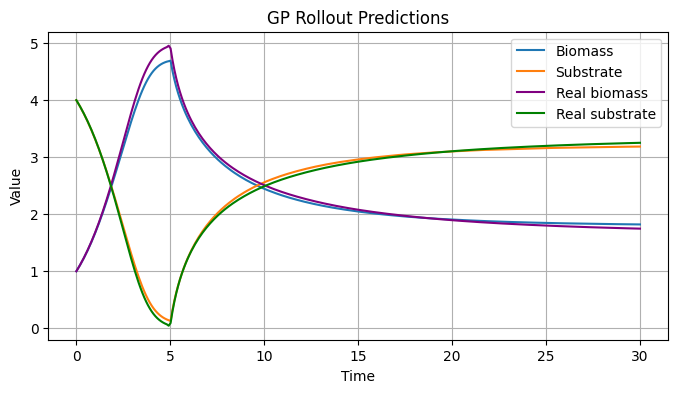

In [14]:
import numpy as np
import torch

# Number of steps
n_steps = len(t_eval)

# Allocate prediction arrays
bm = np.zeros(n_steps)
sm = np.zeros(n_steps)

# Initial values from validation set
bm[0] = Dataset_val['B2'][0]
sm[0] = Dataset_val['S2'][0]
dm = D_func_step_val(t_eval)   # shape (n_steps,)

# Put model in eval mode
model.eval()
likelihood.eval()

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    for t_idx in range(1, n_steps):
        # Build input [1,3] Tensor: [Biomass, Substrate, Dilution]
        x_in = torch.tensor(
            [[bm[t_idx-1], sm[t_idx-1], dm[t_idx-1]]],
            dtype=torch.float32
        )  # shape [1,3]

        # Obtain GP predictive distribution
        pred_dist = likelihood(model(x_in))  
        # pred_dist.mean has shape [1,2] → [batch, outputs]

        # Extract means back to NumPy 
        mean_np = pred_dist.mean.squeeze(0).numpy()  # shape [2]

        # Store for next step
        bm[t_idx] = mean_np[0]
        sm[t_idx] = mean_np[1]

        
#plotting

plt.figure(figsize=(8, 4))
plt.plot(t_eval, bm, label='Biomass')
plt.plot(t_eval, sm, label='Substrate')
plt.plot(t_eval, Dataset_val['B2'], label='Real biomass', color='purple')
plt.plot(t_eval, Dataset_val['S2'], label='Real substrate', color='green')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('GP Rollout Predictions')
plt.legend()
plt.grid(True)
plt.show()

# <u> **Observer** </u>

# <u> Unscented Kalman Filter</u>
In this section it will be attempted to use an Unscented Kalman Filter to account for the wrong initial guess of the Substrate concentration.

The key idea of the UFK is to take sample points around the mean of a gaussian variable and then propagate it through the Neural Network (not the DMD, since the DMD didnt seem to be suited to capture these dynamics), thus using the real model for the dynamics rather than a jacobian. In doing so, the weights attached to the sigma points help to capture the mean and the covariance of the distribution without actual analytical equations of the system dynamics.

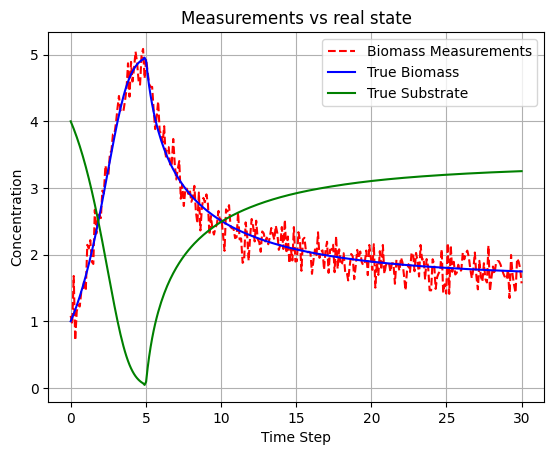

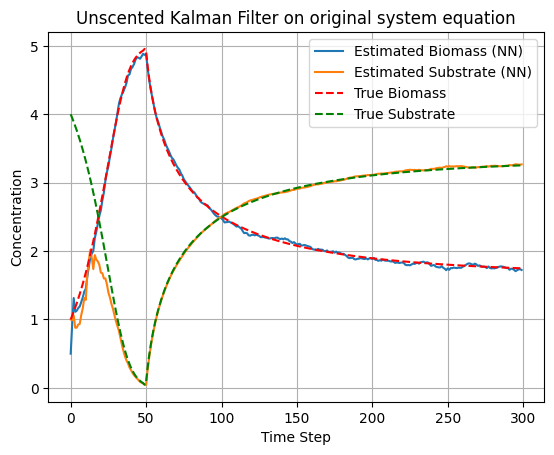

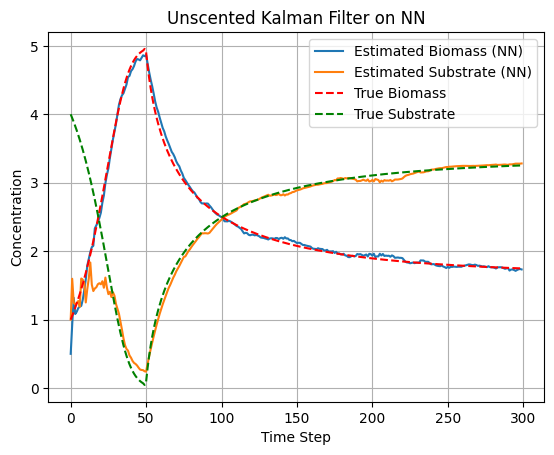

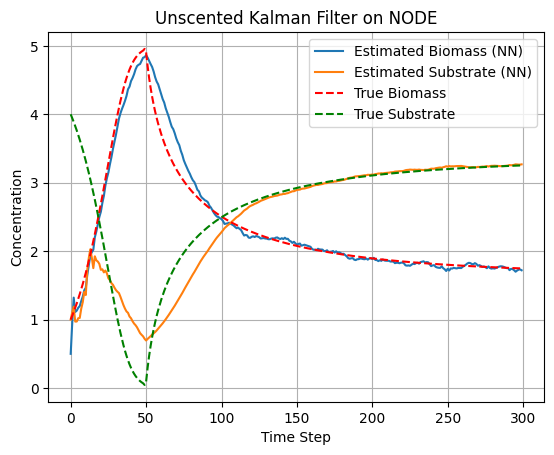

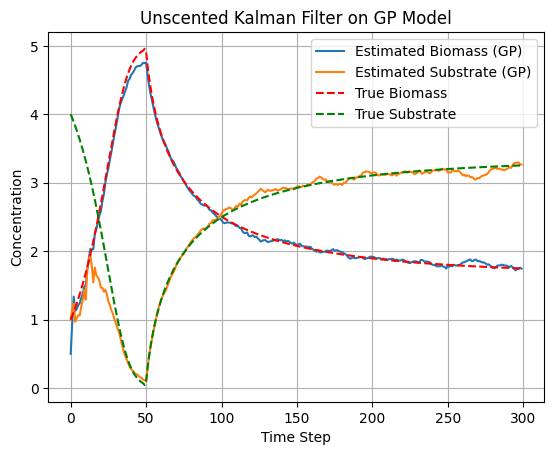

In [15]:
from filterpy.kalman import UnscentedKalmanFilter as UKF
from filterpy.kalman import MerweScaledSigmaPoints
import numpy as np
import torch
import matplotlib.pyplot as plt
#for validation i take the step function that only starts after a few seconds as the input (dataset_val2)
# simulation time is t_eval (which was about 30 seconds i think)

dilution_rate=Dataset_val['U2']

def original_system(x, dt, D_value=None, **kwargs):
     
    if isinstance(x, torch.Tensor):
        x = x.detach().numpy()
    b, s = x
    # insert input value
    biosystem_model.set_D_func(lambda _t, D=D_value: D)
    sol = biosystem_model(t_eval=np.array([0, dt]), y0=x)
    # extract the state at t=dt (the last column)
    b_next, s_next = sol.y[:, -1]
    return np.array([b_next,s_next])

def f_NN(x, dt,D_value=None,**kwargs):
    """State transition function using the neural network. f(x(t)) = x(t+1)"""
    if  not isinstance(x,torch.Tensor):
        x_tensor = torch.tensor(x, dtype=torch.float32)
    else: x_tensor=x

    
    if x_tensor.dim() == 1: # aus [n_features] → [1, n_features] damit man noch den input dazufügen kann
                x_tensor = x_tensor.unsqueeze(0)
    if not isinstance(D_value,torch.Tensor) and D_value is not None:
        D_value=torch.tensor([D_value],dtype=torch.float32)
        D_value = D_value.view(1, 1)            #Annahme, dass D_value ein skalar ist, aber dim (1,1) wird gebraucht

    x_tensor = torch.cat([x_tensor, D_value], dim=1)

    return classicNN_model(x_tensor).detach().numpy()


def Neural_ode(x, dt, D_value=None, **kwargs):
    if not torch.is_tensor(x):
        x = torch.tensor(x, dtype=torch.float32)
    if x.dim() == 1:
        x = x.unsqueeze(0)

    if not torch.is_tensor(D_value):
        u = torch.tensor(D_value, dtype=torch.float32)
    else:
        u = D_value

    #  force u to be 2D [N, dim_u]
    if u.dim() == 0:          # scalar → make [1, 1]
        u = u.unsqueeze(0).unsqueeze(1)
    elif u.dim() == 1:        # vector → make [1, dim_u]
        u = u.unsqueeze(0)
    # if already dim=2, do nothing

    func.u_seq = u.unsqueeze(1) 
    # --- Set func.u_seq and func.t_grid for this step ---
    func.u_seq = u.unsqueeze(1)                     # [N, 1, dim_u]
    func.t_grid = torch.tensor([0.0])               # dummy single time point

    # Time grid for integration step
    t = torch.tensor([0.0, dt], dtype=torch.float32)

    z_traj = odeint(func, x, t, method='dopri5', atol=1e-5, rtol=1e-4)
    z_next = z_traj[-1].detach()

    z_next = z_next.detach()
    if z_next.size(0) == 1:        # [1, dim_x]
        z_next = z_next.squeeze(0) # -> [dim_x]
    return z_next.numpy()
    
    # if z_next.size(0) == 1:
    #     return z_next.squeeze(0).numpy()
    # else:
    #     return z_next.numpy()
    
def GP(x, dt,D_value,**kwargs):
    """State transition function using GP with time not being  part of the input."""
    if not torch.is_tensor(x):
        x = torch.tensor(x, dtype=torch.float32)
    if x.dim() == 1:
        x = x.unsqueeze(0)       # [1,2]
    # now x is [batch,2]

    # 2) Build D as [batch,1]
    if not torch.is_tensor(D_value):
        D_value = torch.tensor(D_value, dtype=torch.float32)
    # If scalar, expand; if 1D of length=batch, make [batch,1]
    if D_value.dim() == 0:
        D = D_value.expand(x.size(0), 1)
    elif D_value.dim() == 1:
        D = D_value.unsqueeze(1)
    else:
        D = D_value
    # now D is [batch,1]

    # 3) Concatenate to [batch,3]
    x_in = torch.cat([x, D], dim=1)

    # 4) Predict
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        pred_dist = likelihood(model(x_in)).mean
    # pred_dist.mean: [batch, output_dim=2]

    # 5) Return the mean (torch.Tensor)
    return pred_dist.detach().numpy()
    
    

#output function
def h(x):
    """Measurement function, in this case only the biomass concentration is measured."""
    return np.array([x[0]])
#Gaussian Process



# State dimension: 2 (b, s)
# Measurement dimension: 1 (b)
dim_x_NN = 2
dim_z = 1
dim_x_GP = 2    # State dimension for GP (b, s) without time, as 1 model doesnt include time in the state and 
                # the other doesnt need "measurements" of the time of measurement



# Create sigma points object
"""As suggested in the documentation 
-alpha is the "spread of the sigma points around the mean state, values between 0 and 1 are common
-beta affects the weight of the central sigma point, typically set to 2 for Gaussian distributions
-kappa is a secondary scaling parameter, often set to 0 for simplicity."""
points_NN = MerweScaledSigmaPoints(n=dim_x_NN, alpha=0.1, beta=2.0, kappa=0.0)
points_GP = MerweScaledSigmaPoints(n=dim_x_GP, alpha=0.1, beta=2.0, kappa=0.0)

#-------------------for the NN-----------------------------
# Create UKF object for the NN
ukf_original = UKF(dim_x=dim_x_NN, dim_z=dim_z, fx=original_system, hx=h, dt=t_eval[1]-t_eval[0], points=points_NN)
ukf_NN = UKF(dim_x=dim_x_NN, dim_z=dim_z, fx=f_NN, hx=h, dt=t_eval[1]-t_eval[0], points=points_NN)
ukf_NODE = UKF(dim_x=dim_x_NN, dim_z=dim_z, fx=Neural_ode, hx=h, dt=t_eval[1]-t_eval[0], points=points_NN)
ukf_GP = UKF(dim_x=dim_x_GP, dim_z=dim_z, fx=GP, hx=h, dt=t_eval[1]-t_eval[0], points=points_GP)


x0=np.array([0.5,1])
# Initial state guess (e.g., wrong values)
ukf_original.x = x0
ukf_NN.x = x0
ukf_NODE.x = x0
ukf_GP.x = x0


# Initial covariance (uncertainty in state)
ukf_original.P = np.eye(dim_x_NN)*3 # Initial covariance matrix for the original system

ukf_NN.P = np.eye(dim_x_NN) * 3 # You can tune this
ukf_NODE.P=np.eye(dim_x_NN) * 3
ukf_GP.P = np.eye(dim_x_GP) * 3  # Adjusted for correct dimension


# Process noise (model uncertainty)
ukf_original.Q = np.diag([1e-3, 1e-3]) 
ukf_NN.Q = np.diag([1e-3, 1e-3])         # Tune this based on how inaccurate your NN is
ukf_NODE.Q=np.diag([1e-3, 1e-3])  
ukf_GP.Q = np.diag([1e-3, 1e-3])   

# Measurement noise (e.g., sensor error in b, but i should not have any noise since i simulated with the ODE for the measurement)
ukf_original.R = np.array([0.2])
ukf_NN.R = np.array([[0.2]])  # Measurement noise variance
ukf_NODE.R=  np.array([0.2])
ukf_GP.R = np.array([[0.2]])  # Match NN



#assume noise measurements
noise = np.random.normal(loc=0.0, scale=0.2, size=Dataset_val['B2'].shape)
b_measurements = Dataset_val['B2'][0:]+noise  # Use the biomass measurements for updating the filter

estimated_states_original = [ukf_original.x.copy()]
estimated_states_NN = [ukf_NN.x.copy()]  # Store the initial state (used for plotting)
estimated_states_NODE = [ukf_NODE.x.copy()]
estimated_states_GP = [ukf_GP.x.copy()]


time_index=0
for z in b_measurements[1:]:  # Skip the first measurement since i assume the measurement is not available at t=0,but the input is
    D_value = Dataset_val['U2'][time_index]


    ukf_original.predict(D_value=D_value)
    ukf_original.update(np.array([z]))
    estimated_states_original.append(ukf_original.x.copy())

    ukf_NN.predict(D_value=D_value)
    ukf_NN.update(np.array([z]))
    estimated_states_NN.append(ukf_NN.x.copy())

    ukf_NODE.predict(D_value=D_value)
    ukf_NODE.update(np.array([z]))
    estimated_states_NODE.append(ukf_NODE.x.copy())

    ukf_GP.predict(D_value=D_value)
    ukf_GP.update(np.array([z]))
    estimated_states_GP.append(ukf_GP.x.copy())
    time_index+=1

#--------------------- Plotting Section ---------------------------

plt.figure()
plt.title('Measurements vs real state')
plt.plot(t_eval, b_measurements, 'r--', label='Biomass Measurements')
plt.plot(t_eval, Dataset_val['B2'], 'b-', label='True Biomass')
plt.plot(t_eval, Dataset_val['S2'], 'g-', label='True Substrate')
plt.xlabel('Time Step')
plt.ylabel('Concentration')
plt.legend()
plt.grid(True)
plt.show()

#original equation estimation
estimated_states_original = np.array(estimated_states_original)
plt.figure()
plt.title('Unscented Kalman Filter on original system equation')
plt.plot(estimated_states_original[:, 0], label='Estimated Biomass (NN)')
plt.plot(estimated_states_original[:, 1], label='Estimated Substrate (NN)')
plt.plot(Dataset_val['B2'], 'r--', label='True Biomass')
plt.plot(Dataset_val['S2'], 'g--', label='True Substrate')
plt.xlabel('Time Step')
plt.ylabel('Concentration')
plt.legend()
plt.grid(True)
plt.show()

#NN results
estimated_states_NN = np.array(estimated_states_NN)
plt.figure()
plt.title('Unscented Kalman Filter on NN')
plt.plot(estimated_states_NN[:, 0], label='Estimated Biomass (NN)')
plt.plot(estimated_states_NN[:, 1], label='Estimated Substrate (NN)')
plt.plot(Dataset_val['B2'], 'r--', label='True Biomass')
plt.plot(Dataset_val['S2'], 'g--', label='True Substrate')
plt.xlabel('Time Step')
plt.ylabel('Concentration')
plt.legend()
plt.grid(True)
plt.show()

estimated_states_NODE = np.array(estimated_states_NODE)
plt.figure()
plt.title('Unscented Kalman Filter on NODE')
plt.plot(estimated_states_NODE[:, 0], label='Estimated Biomass (NN)')
plt.plot(estimated_states_NODE[:, 1], label='Estimated Substrate (NN)')
plt.plot(Dataset_val['B2'], 'r--', label='True Biomass')
plt.plot(Dataset_val['S2'], 'g--', label='True Substrate')
plt.xlabel('Time Step')
plt.ylabel('Concentration')
plt.legend()
plt.grid(True)
plt.show()

#GP-based UKF results
estimated_states_GP = np.array(estimated_states_GP)
plt.figure()
plt.title('Unscented Kalman Filter on GP Model')
plt.plot(estimated_states_GP[:, 0], label='Estimated Biomass (GP)')
plt.plot(estimated_states_GP[:, 1], label='Estimated Substrate (GP)')
plt.plot(Dataset_val['B2'], 'r--', label='True Biomass')
plt.plot(Dataset_val['S2'], 'g--', label='True Substrate')
plt.xlabel('Time Step')
plt.ylabel('Concentration')
plt.legend()
plt.grid(True)
plt.show()





# <u> Extended Kalman Filter </u>
Just as the "Normal Kalman Filter" the Extended Kalman Filter also uses the Ricatti equation to find the optimal Kalman gain, but instead of the linear System Matrix A, we approximate the linear dynamics by calculating the Jacobian of our Nonlinear System.
$$
\begin{align*}
x_k &= f(x_{k-1}, u_{k-1}) + w_{k-1}, \quad w_{k-1} \sim \mathcal{N}(0, Q) \\
z_k &= h(x_k) + v_k, \quad v_k \sim \mathcal{N}(0, R)
\end{align*}
$$
$$

\begin{align*}
\text{State Prediction:} \quad &\hat{x}_{p,k} = f(\hat{x}_{k-1}, u_{k-1}) \\
\text{Jacobian of dynamics:} \quad &F_{k-1} = \left. \frac{\partial f}{\partial x} \right|_{x = \hat{x}_{k-1}, u = u_{k-1}} \\
\text{Covariance Prediction:} \quad &P_{p,k} = F_{k-1} P_{k-1} F_{k-1}^\top + Q
\end{align*}
$$
$$
\begin{align*}
\text{Jacobian of measurement:} \quad &H_k = \left. \frac{\partial h}{\partial x} \right|_{x = \hat{x}_{k}} \\
\text{Kalman Gain:} \quad &K_k = P_{p,k} H_k^\top (H_k P_{p,k} H_k^\top + R)^{-1} \\
\text{State Update:} \quad &\hat{x}_{k} = \hat{x}_{p,k} + K_k (z_k - h(\hat{x}_{p,k})) \\
\text{Covariance Update:} \quad &P_{k} = (I - K_k H_k) P_{p,k}
\end{align*}
$$
where $p$ -index stands for the predicted value 

Evaluation after simulation with the "perfect" system model (the model that was used to generate the data):
The Kalman Filter is not suited to capture the nonlinear dynamics in a proper way

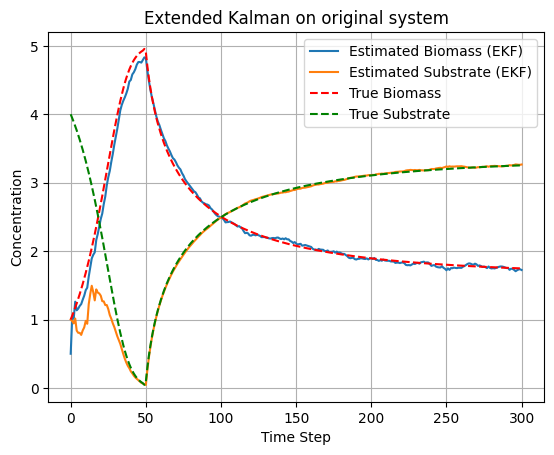

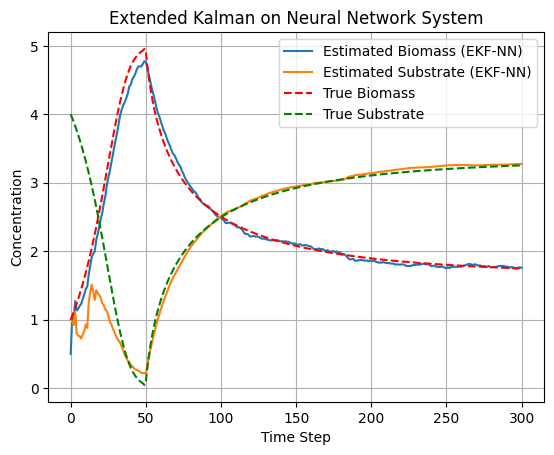

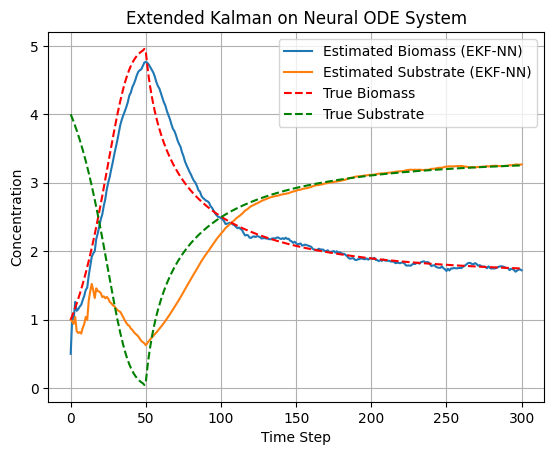

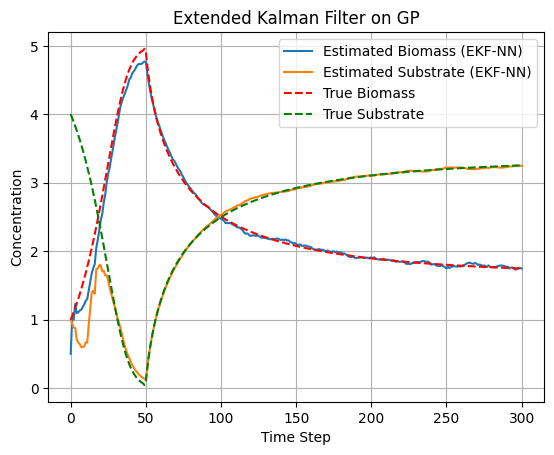

In [28]:
import numpy as np

# def Biosystem(x,dt, D, K_m, s_e, mu_max):
#     b, s = x
#     rho = mu_max * s / (K_m + s)
#     dbdt = -D * b + rho * b
#     dsdt = D * (s_e - s) - rho * b

#     b = b + dbdt * dt
#     s = s + dsdt * dt
#     return np.array([b, s])

def compute_jacobian_analytical(x, dt, D_value, K_m, s_e, mu_max,**kwargs):
    b, s = x
    rho = mu_max * s / (K_m + s)
    drho_ds = mu_max * K_m / (K_m + s)**2

    df1_db = -D_value + rho
    df1_ds = b * drho_ds

    df2_db = -rho
    df2_ds = -D_value - b * drho_ds

    F = np.array([[1 + df1_db * dt, df1_ds * dt],
                  [df2_db * dt, 1 + df2_ds * dt]])
    return F

def compute_jacobian_autograd(x_input, dt=None, D_value=None, **kwargs):
    model = kwargs['model']   # classicNN_model will be passed here

    # --- ensure state has grad
    x = torch.tensor(x_input, dtype=torch.float32, requires_grad=True)
    if x.dim() == 1:
        x = x.unsqueeze(0)   # -> [1, dim_x]

    # --- ensure D_value is a 2D tensor (no grad)
    u = torch.tensor(D_value, dtype=torch.float32)
    if u.dim() == 0:
        u = u.unsqueeze(0).unsqueeze(1)  # scalar -> [[D]]
    elif u.dim() == 1:
        u = u.unsqueeze(0)               # vector -> [1, dim_u]

    # --- concat along features
    xu = torch.cat([x, u], dim=-1)  # [1, dim_x + dim_u]

    # --- forward pass
    y = model(xu)                   # [1, dim_x]

    # --- flatten output (safe for batch of size 1)
    y = y.view(-1)                  # -> [dim_x]

    # --- compute Jacobian wrt x only
    jacobian = []
    for i in range(y.shape[0]):
        grad_x = torch.autograd.grad(y[i], x, retain_graph=True)[0]  # grad_x is [1, dim_x]
        jacobian.append(grad_x.squeeze(0).detach().numpy())          # squeeze(0) → [dim_x]

    return np.stack(jacobian, axis=0)   # final shape [dim_x, dim_x]

def compute_jacobian_NODE(x_input, dt=None, **kwargs):
    """Compute discrete-time Jacobian for NODE (F = I + J*dt)."""
    model = kwargs['model']  # ODEFunc instance
    x_input = torch.tensor(x_input, dtype=torch.float32)
    x = x_input.clone().detach().requires_grad_(True)

    if x.dim() == 1:
        x = x.unsqueeze(0)    # [1, dim_x] this line is not needed anymore (now already handled in the ODEfunc itself!)

    dxdt = model(0, x)        # returns f(x), shape [1, dim_x]
    dxdt = dxdt.view(-1)      # flatten to (dim_x,)

    jacobian = []
    for i in range(dxdt.shape[0]):
        grad = torch.autograd.grad(dxdt[i], x, retain_graph=True)[0]
        grad = grad.squeeze(0)                   #  remove batch dim → (dim_x,) this line is not needed anymore, but doenst affect the code negatively either
        jacobian.append(grad.detach().numpy())

    J = np.stack(jacobian, axis=0)               # shape (dim_x, dim_x)
    return np.eye(len(x_input)) + J * dt



def finite_difference_jacobian_gp_bs(x_input,dt=None,D_value=None , eps=1e-2,**kwargs):
    """
    Computes Jacobian of GP output w.r.t. biomass and substrate only.

    Args:
        model: GP model
        likelihood: GP likelihood
        x: [biomass, substrate]
        D: dilution (scalar)
        eps: finite difference step
    Returns:
        jacobian: [n_outputs, 2] numpy array
    """
    model=kwargs['model']
    x_in = torch.tensor([[float(x_input[0]), float(x_input[1]), float(D_value)]], dtype=torch.float32)
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        pred = likelihood(model(x_in))
        y0 = pred.mean.squeeze(0)
    n_outputs = y0.shape[0]
    jacobian = np.zeros((n_outputs, 2))

    for i in range(2):  # Only biomass and substrate
        x_plus = x_in.clone()
        x_plus[0, i] += eps
        with torch.no_grad(), gpytorch.settings.fast_pred_var():
            pred = likelihood(model(x_plus))
            y_plus = pred.mean.squeeze(0)
        jacobian[:, i] = ((y_plus - y0)/eps).numpy()
    return jacobian


def compute_jacobian_h(x):
    # Measurement is only b, so derivative is [1, 0]
    return np.array([[1, 0]])

   
def extended_kalman_filter_discrete_input(system_fn, jacobian_f, jacobian_h,
                           y_measurements, x0, P0, Q, R, dt,
                           D_value=0, **kwargs):
    '''
        Parameters:
            system_fn:      Model of the system that takes current state input x_k and yields x_(k+1)
            jacobian_f:     Jacobian of the Model (in discrete time!!!)--> F=I+J*dt where J is the Jacobian of the conti-time system
            jacobian_h:     Jacobian of the ouptut function
            y_measurements: (Noisy) Measurements of the output at discrete times t
            x0:              Estimate of the original state
            P0:              Estimate of initial error Covariance
            Q:               Covariance of Process Noise
            R:               Covariance of Measurement-Noise
            dt:              Time between measurement samples
            D_value         Different from UKF here i expect the user (ideally) to pass the whole series of inputs at once.
            **kwargs         All arguments that also need to be passed to the system_fn (like K_m u_max)


        Output:
            x_est: estimate of the state

    
    this function also exists in my helperfunction.py, but i also wanted it in this file for presentation on thursday'''
    n = len(y_measurements)
    x_est = np.zeros((n, 2))
    x = x0.copy()
    P = P0.copy()

    for k in range(n):
        if D_value is not None:
            u_k = D_value[k]  #  take the input at step k
        else: u_k = 0
        # === Prediction step ===
        x_pred = system_fn(x, dt, D_value=u_k, **kwargs)
        x_pred = np.asarray(x_pred).flatten()   #  now always (2,). The NN returned a (1,2) with 1 being the nr of batches, which then caused an error in matmul
    
        F = jacobian_f(x, dt, D_value=u_k, **kwargs)
        P_pred = F @ P @ F.T + Q

        # === Update step ===
        H = jacobian_h(x_pred)
        dy = y_measurements[k] - H @ x_pred
        S = H @ P_pred @ H.T + R
        K = P_pred @ H.T @ np.linalg.inv(S)

        x = x_pred + K @ dy
        P = (np.eye(2) - K @ H) @ P_pred

        x_est[k] = x

    return np.vstack([x0, x_est])

dt = t_eval[1]-t_eval[0]  # 1/10
ys = b_measurements # observations of biomass only already added noise to it (in the UKF box)

x0 = np.array([0.5, 1.0])  # Initial state [b, s]
P = np.eye(2) * 2         # Initial covariance
Q = np.diag([1e-3, 1e-3])  # Process noise
R = np.array([[0.2]])     

# model parameters (equal to the real ones used for the DGL)
D_value=Dataset_val['U2']
K_m = 2
s_e = 5
mu_max = 0.8

x_estimates = extended_kalman_filter_discrete_input(original_system,compute_jacobian_analytical,compute_jacobian_h,ys, x0, P, Q, R, dt,D_value=D_value,
                                      K_m=biosystem_model.K_m, s_e=biosystem_model.s_e, mu_max=biosystem_model.mu_max,)#kwargs 
x_estimates_NN = extended_kalman_filter_discrete_input(f_NN,compute_jacobian_autograd,compute_jacobian_h,ys, x0, P, Q, R, dt,D_value=D_value,
                                        model=classicNN_model)
x_estimates_NODE = extended_kalman_filter_discrete_input(Neural_ode,compute_jacobian_NODE,compute_jacobian_h,ys, x0, P, Q, R, dt,D_value=D_value,
                                        model=func)
x_estimates_GP =extended_kalman_filter_discrete_input(GP,finite_difference_jacobian_gp_bs,compute_jacobian_h,ys, x0, P, Q, R, dt,D_value=D_value,
                                        model=model)

plt.figure()
plt.title('Extended Kalman on original system')
estimation_results = np.array(x_estimates)
plt.plot(x_estimates[:, 0], label='Estimated Biomass (EKF)')
plt.plot(x_estimates[:, 1], label='Estimated Substrate (EKF)')
plt.plot(Dataset_val['B2'], 'r--', label='True Biomass')
plt.plot(Dataset_val['S2'], 'g--', label='True Substrate')
plt.xlabel('Time Step')
plt.ylabel('Concentration')
plt.legend()
plt.grid(True)
plt.show()


plt.figure()
plt.title('Extended Kalman on Neural Network System')
x_estimates_NN = np.array(x_estimates_NN)
plt.plot(x_estimates_NN[:, 0], label='Estimated Biomass (EKF-NN)')
plt.plot(x_estimates_NN[:, 1], label='Estimated Substrate (EKF-NN)')
plt.plot(Dataset_val['B2'], 'r--', label='True Biomass')
plt.plot(Dataset_val['S2'], 'g--', label='True Substrate')
plt.xlabel('Time Step')
plt.ylabel('Concentration')
plt.legend()
plt.grid(True)
plt.show()

plt.figure()
plt.title('Extended Kalman on Neural ODE System')
x_estimates_NODE = np.array(x_estimates_NODE)
plt.plot(x_estimates_NODE[:, 0], label='Estimated Biomass (EKF-NN)')
plt.plot(x_estimates_NODE[:, 1], label='Estimated Substrate (EKF-NN)')
plt.plot(Dataset_val['B2'], 'r--', label='True Biomass')
plt.plot(Dataset_val['S2'], 'g--', label='True Substrate')
plt.xlabel('Time Step')
plt.ylabel('Concentration')
plt.legend()
plt.grid(True)
plt.show()

plt.figure()
plt.title("Extended Kalman Filter on GP")
x_estimates_GP=np.array(x_estimates_GP)
plt.plot(x_estimates_GP[:, 0], label='Estimated Biomass (EKF-NN)')
plt.plot(x_estimates_GP[:, 1], label='Estimated Substrate (EKF-NN)')
plt.plot(Dataset_val['B2'], 'r--', label='True Biomass')
plt.plot(Dataset_val['S2'], 'g--', label='True Substrate')
plt.xlabel('Time Step')
plt.ylabel('Concentration')
plt.legend()
plt.grid(True)
plt.show()



# Moving Horizon Estimation (MHE)

Moving Horizon Estimation is an optimization-based state estimation technique that uses a sliding window of past measurements.

## Mathematical Formulation

The MHE optimization problem at time $t_k$ is:

$$
\min_{x_{k-H:k}}
\bigl(x_{k-H} - \hat x_{k-H\mid k-1}\bigr)^{T}P_{a}^{-1}\bigl(x_{k-H} - \hat x_{k-H\mid k-1}\bigr)
\;+\;
\sum_{i=k-H}^{k}\bigl\|y_{i}-C\,x_{i}\bigr\|^{2}
\;+\;
\sum_{i=k-H}^{k-1}\bigl\|x_{i+1}-f_{\theta}(x_{i},u_{i})\bigr\|^{2}
$$



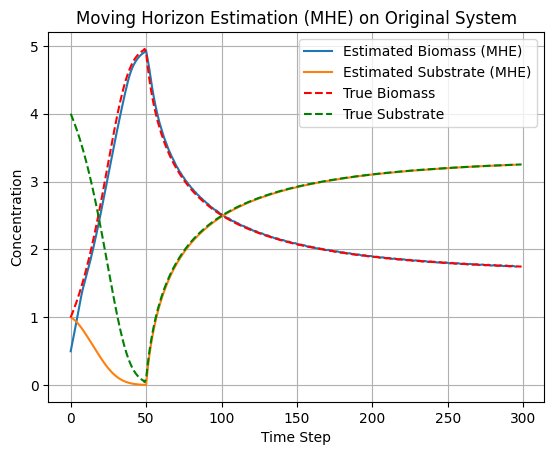

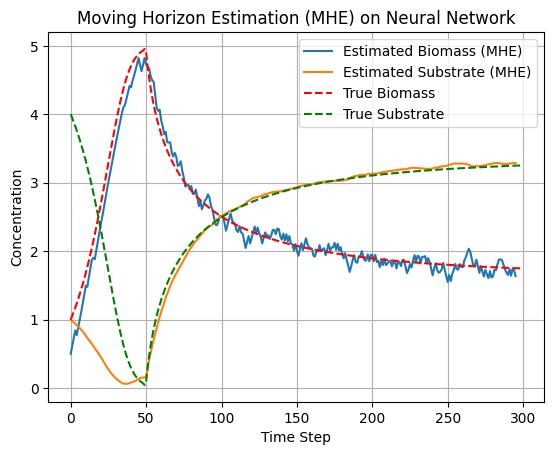

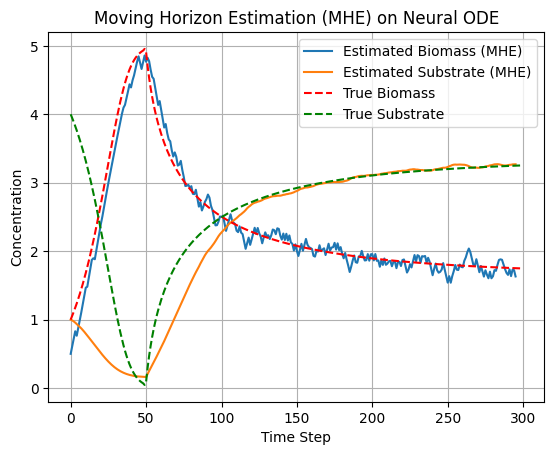

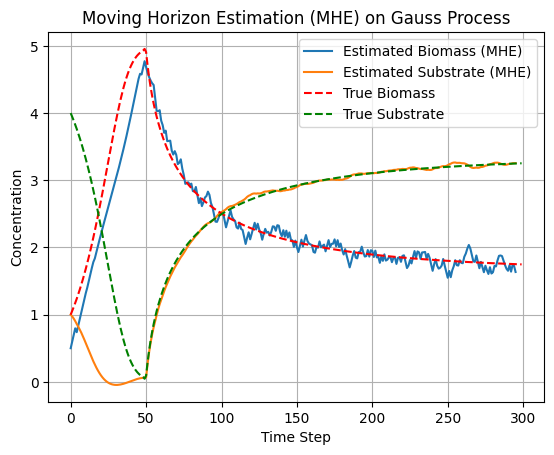

In [17]:
import torch
import torch.optim as optim
import numpy as np

import torch
import torch.optim as optim
import numpy as np


def mhe_estimate(model, y_meas, u_seq=None, window_size=5,
                 x_init_guess=None, num_iter=10, lr=1e-2,
                 Q_diag=None, R_diag=None, P_diag=None, **kwargs):
    """
    Moving Horizon Estimation with explicit process noise variables w_k.

    Args:
        model:      function mapping x_k and optional input to x_{k+1}
        y_meas:     array of measurements (length H)
        u_seq:      array of control inputs (length H-1) or None
        window_size:number of steps in each estimation window
        x_init_guess:initial guess for state vector (1D array, length state_dim)
        num_iter:   number of optimizer steps per window shift
        lr:         learning rate for Adam
        Q_diag:     process noise covariance diagonal (array or scalar)
        R_diag:     measurement noise covariance diagonal
        P_diag:     prior covariance diagonal for arrival cost
    Returns:
        np.ndarray of estimated states at each shift (shape [H-window_size+1, state_dim])
    """
    H = len(y_meas)
    nshifts = H - window_size + 1

    # convert covariances to torch weights
    Q_inv = torch.tensor(1.0 / np.array(Q_diag), dtype=torch.float32) if Q_diag is not None else 1.0
    R_inv = torch.tensor(1.0 / np.array(R_diag), dtype=torch.float32) if R_diag is not None else 1.0
    P_inv = torch.tensor(1.0 / np.array(P_diag), dtype=torch.float32) if P_diag is not None else 1.0

    # flatten initial guess to 1D
    prev_state = torch.tensor(x_init_guess, dtype=torch.float32).view(-1)
    state_dim = prev_state.numel()

    estimated_states = []
    for shift in range(nshifts):
        # decision variables: initial state x0 and noise sequence w
        x0 = prev_state.clone().requires_grad_(True)
        w = torch.zeros((window_size - 1, state_dim), dtype=torch.float32, requires_grad=True)

        optimizer = optim.Adam([x0, w], lr=lr)
        for _ in range(num_iter):
            optimizer.zero_grad()

            # arrival cost on x0
            loss = torch.sum(P_inv * (x0 - prev_state).pow(2))

            # propagate through window
            x_k = x0
            for t in range(window_size - 1):
                # model prediction expects 1D numpy; we convert and back
                x_pred = model(x_k.detach().numpy(), **({} if u_seq is None else {"D_value": u_seq[shift + t], **kwargs}))
                x_pred = torch.tensor(np.array(x_pred), dtype=torch.float32).view(-1)

                # apply explicit process noise
                w_k = w[t]
                x_k = x_pred + w_k
                loss = loss + torch.sum(Q_inv * w_k.pow(2))

                # measurement penalty on first state component
                y_t = torch.tensor(y_meas[shift + t], dtype=torch.float32)
                loss = loss + (y_t - x_k[0]).pow(2) * R_inv

            # final measurement at window end
            y_last = torch.tensor(y_meas[shift + window_size - 1], dtype=torch.float32)
            loss = loss + (y_last - x_k[0]).pow(2) * R_inv

            loss.backward()
            optimizer.step()

        # record estimated x0
        estimated_states.append(x0.detach().numpy())

        # advance prev_state by one step: f(x0) + w[0]
        pred_np = model(x0.detach().numpy(), **({} if u_seq is None else {"D_value": u_seq[shift], **kwargs}))
        pred_torch = torch.tensor(np.array(pred_np), dtype=torch.float32).view(-1)
        prev_state = pred_torch + w[0].detach()

    return np.vstack(estimated_states)




window_size = 5
x_init_guess_Biosystem = np.array([[0.5, 1]])
dilution_rate=Dataset_val['U2']
P = np.eye(2) * 1         # Initial covariance
Q = np.diag([1, 1])  # Process noise
R = np.array([[1]])  

# for i in range(1, window_size):
#     x0 = x_init_guess_Biosystem[-1]
#     x_next = original_system(x0, dt=t_eval[1] - t_eval[0],D_value=D_value[i])
#     x_init_guess_Biosystem = np.vstack([x_init_guess_Biosystem, x_next])
x_MHE_GP   = mhe_estimate(GP,b_measurements,u_seq=dilution_rate,window_size=window_size,x_init_guess=x_init_guess_Biosystem.flatten(),Q=Q,R=R,P=P,dt=t_eval[1]-t_eval[0])
x_MHE_NN= mhe_estimate(f_NN,b_measurements,u_seq=dilution_rate,window_size=window_size,x_init_guess=x_init_guess_Biosystem,Q=Q,R=R,P=P,dt=t_eval[1]-t_eval[0])
x_MHE_original_Biosystem=mhe_estimate(original_system,Dataset_val['B2'],u_seq=dilution_rate,window_size=window_size,x_init_guess=x_init_guess_Biosystem.flatten(),Q=Q,R=R,P=P,dt=t_eval[1]-t_eval[0])

x_MHE_NODE = mhe_estimate(Neural_ode,b_measurements,u_seq=dilution_rate,window_size=window_size,x_init_guess=x_init_guess_Biosystem,Q=Q,R=R,P=P,dt=t_eval[1]-t_eval[0])

plt.figure()
plt.title('Moving Horizon Estimation (MHE) on Original System')
plt.plot(x_MHE_original_Biosystem[:, 0], label='Estimated Biomass (MHE)')
plt.plot(x_MHE_original_Biosystem[:, 1], label='Estimated Substrate (MHE)')
plt.plot(Dataset_val['B2'], 'r--', label='True Biomass')
plt.plot(Dataset_val['S2'], 'g--', label='True Substrate')
plt.xlabel('Time Step')
plt.ylabel('Concentration')
plt.legend()
plt.grid(True)
plt.show()


plt.figure()
plt.title('Moving Horizon Estimation (MHE) on Neural Network')
plt.plot(x_MHE_NN[:, 0], label='Estimated Biomass (MHE)')
plt.plot(x_MHE_NN[:, 1], label='Estimated Substrate (MHE)')
plt.plot(Dataset_val['B2'], 'r--', label='True Biomass')
plt.plot(Dataset_val['S2'], 'g--', label='True Substrate')
plt.xlabel('Time Step')
plt.ylabel('Concentration')
plt.legend()
plt.grid(True)
plt.show()

plt.figure()
plt.title('Moving Horizon Estimation (MHE) on Neural ODE')
plt.plot(x_MHE_NODE[:, 0], label='Estimated Biomass (MHE)')
plt.plot(x_MHE_NODE[:, 1], label='Estimated Substrate (MHE)')
plt.plot(Dataset_val['B2'], 'r--', label='True Biomass')
plt.plot(Dataset_val['S2'], 'g--', label='True Substrate')
plt.xlabel('Time Step')
plt.ylabel('Concentration')
plt.legend()
plt.grid(True)
plt.show()

plt.figure()
plt.title('Moving Horizon Estimation (MHE) on Gauss Process')
plt.plot(x_MHE_GP[:, 0], label='Estimated Biomass (MHE)')
plt.plot(x_MHE_GP[:, 1], label='Estimated Substrate (MHE)')
plt.plot(Dataset_val['B2'], 'r--', label='True Biomass')
plt.plot(Dataset_val['S2'], 'g--', label='True Substrate')
plt.xlabel('Time Step')
plt.ylabel('Concentration')
plt.legend()
plt.grid(True)
plt.show()


In [18]:
# print(x_MHE_NN)